# What & Why
This notebook is inspired by the [second part](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2) of Jeremy's solution of [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification) competition.

It explores effects of
* speed up from working on smaller image sizes
* using more recent model architecture (ConvxNet)
* exploring impact of augmentation during training
* test time augmentation

# Python packages setup & data download

This part is copied from the [01-baseline.ipynb](./01-baseline.ipynb)

In [1]:
USE_LATEST_PIP_PACKAGES = True

In [2]:
import os
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    print("Running notebook in kaggle mode")
else:
    print("Running notebook in Paperspace mode")

Running notebook in Paperspace mode


In [3]:
# install Jeremy's fastkaggle package with helpers for Kaggle API
try:
    import fastkaggle
except ModuleNotFoundError:
    if is_kaggle:
        print("installing fastkaggle into system folder on Kaggle")
        !pip install -q fastkaggle
    else:
        print("installing fastkaggle into user (/root/.local/) folder on Paperspace")
        # we are installing into local folder
        !pip install --user -q fastkaggle

from fastkaggle import setup_comp, push_notebook

In [4]:
# Jeremy's philosophy is to always work on latest versions of all packages 
# and don't bother with creating and tracking Python environments with the fixed set of packages
# I still like to have full replica of the env, so plan to add it as a fallback
if not is_kaggle:
    if USE_LATEST_PIP_PACKAGES:
        !pip install --user -Uqq timm huggingface_hub fastai
    else:
        !pip install --user  --no-cache-dir -r ../requirements.txt

## Get competition data

In [5]:
# setup_comp downloads competition dataset archive into the current folder and extracts into subfolder
# it also pip-installs libraries when if we are on Kaggle
COMPETITION_NAME = 'paddy-disease-classification'

path = setup_comp(COMPETITION_NAME, install='timm huggingface_hub fastai')

In [6]:
import pandas as pd

In [7]:
# import fastai only after we updated all packages on Kaggle or locally
from fastai.vision.all import *
from fastcore.parallel import *
set_seed(42)

In [8]:
path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv')]

# Quick look at data

In [9]:
train_path = path / "train_images"

In [10]:
train_files = get_image_files(train_path)

File:  paddy-disease-classification/train_images/tungro/100723.jpg
Size:  (480, 640)


<AxesSubplot:>

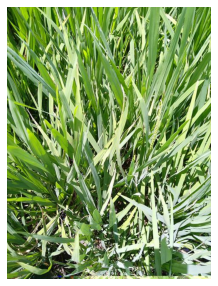

In [11]:
# show single file
idx = 2002
img = PILImage.create(train_files[idx])
print("File: ", train_files[idx])
print("Size: ", img.size)
img.show()

In [12]:
%%time
def get_image_size(file_path):
    return PILImage.create(file_path).size

assert get_image_size(train_files[0]) == (480, 640)


sizes = parallel(get_image_size, train_files, n_workers=8)
pd.Series(sizes).value_counts()

CPU times: user 4.96 s, sys: 1.21 s, total: 6.17 s
Wall time: 35.3 s


(480, 640)    10403
(640, 480)        4
dtype: int64

# Helpers to train the model

In [13]:
def train(train_path, model_arch, item_transforms, batch_transforms, n_epochs):
    dls = ImageDataLoaders.from_folder(
        train_path, 
        valid_pct=0.2, 
        seed=42, 
        item_tfms=item_transforms,
        batch_tfms=batch_transforms,
    )
    learn = vision_learner(dls, model_arch, metrics=error_rate, path='.').to_fp16()
    learn.fine_tune(n_epochs, 0.01) #we use Lr selecte in the previous notebook usign learn.lr_find
    return learn

# 1. Resnet, experiment with resizing

We couldn't train without resizing because we have 4 examples with different aspect ratios. 
The following code fails because DataLoader couldn't create a batch from images of different shapes:
```
learn, dls = train(train_path, "resnet26d", None, None, 3)
```

*Error:*
```
RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 640, 480])
	Item at index 24 has shape: torch.Size([3, 480, 640])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size
```

## 1.1 Resize to 20% of original size, No batch augmentation

In [14]:
%%time
# the order of dimensions is different from PIL:
#   number of rows is the first element in the tuple for tensors but second for PIL.
learn = train(train_path, "resnet26d", Resize((128, 96)), None, 3)

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.675071,1.166732,0.345987,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.895962,0.712371,0.214320,00:26
1,0.400200,0.489801,0.141278,00:25
2,0.135558,0.447431,0.127343,00:26


CPU times: user 59.4 s, sys: 17.7 s, total: 1min 17s
Wall time: 1min 58s


On paperspace:
* overall duration: 1min 58sec
* per epoch: ~26sec
* err rate: 0.1273

Utilisation of 
* GPU ~80-100%
* GPU memory ~50%
* CPU ~500% (based on paperspace UI)

## 1.2 Resize to 40% of original size, No batch augmentation

In [15]:
%%time
learn = train(train_path, "resnet26d", Resize((256, 192)), None, 3)

epoch,train_loss,valid_loss,error_rate,time
0,1.363232,0.892381,0.269101,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.690403,0.540588,0.164825,00:57
1,0.315402,0.344597,0.105718,00:57
2,0.093328,0.289761,0.085536,00:58


CPU times: user 2min 18s, sys: 1min 2s, total: 3min 20s
Wall time: 3min 40s


On paperspace:
* overall duration: 3min 40sec
* per epoch: 57sec 🟡
* err rate: 0.085  🟢 (bigger input -> better resuls)

## 1.3 Keep original size, No batch augmentation

In [16]:
%%time
if False:
    learn = train(train_path, "resnet26d", Resize((640, 480)), None, 3)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.58 µs


On paperspace:
* overall duration: 20min 8sec
* per epoch: 5min 17sec 🟡
* err rate: 0.068       🟢 (bigger input -> better resuls)

Utilisation:
* GPU 100%
* GPU memory ~50%
* CPU ~130% (based on paperspace UI)

## 1.3 Use baseline config (480x480 -> 128)
Let's use config from the [01-baseline.ipynb](./01-baseline.ipynb)
* resize to square 480 on the fly
* batch augmentation resize 128, min_scale=0.75

In [17]:
%%time
learn = train(train_path, "resnet26d", 
              Resize(480, method='squish'), 
              aug_transforms(size=128, min_scale=0.75), 
              3)

epoch,train_loss,valid_loss,error_rate,time
0,1.754669,1.179611,0.379625,00:35


epoch,train_loss,valid_loss,error_rate,time
0,1.151115,0.812931,0.263815,00:39
1,0.783423,0.484037,0.154733,00:40
2,0.538113,0.404711,0.130226,00:39


CPU times: user 1min 33s, sys: 37.5 s, total: 2min 11s
Wall time: 2min 37s


On paperspace:
* overall duration: 2min 37sec
* per epoch: 40sec
* err rate: 0.13

Utilisation of 
* GPU 70-80%
* GPU memory ~50%
* CPU  500%

Observation: resizing to (128, 96) with no batch augmentaiton was 50sec faster and provided slightly better results (0.127 err rate) 

# 2. Downscale images outside dataloader

In [18]:
# check how resize_image works on a single file

File:  paddy-disease-classification/train_images/bacterial_panicle_blight/109162.jpg
Size:  (480, 640)


<AxesSubplot:>

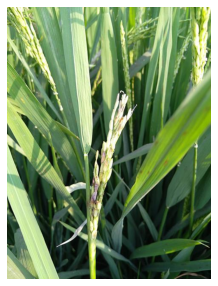

In [19]:
img_path = train_files[0]
img = PILImage.create(img_path)
print("File: ", img_path)
print("Size: ", img.size)
img.show()

New size:  (96, 128)


<AxesSubplot:>

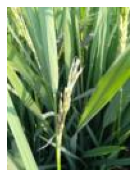

In [20]:
dest = Path('temp_img')
resize_image(img_path.name, # name of the file
             dest=dest,     # directory where to put resized image
             src=img_path.parent, # directory where to look for the source file
             max_size=128)
img = PILImage.create(dest/img_path.name)
print("New size: ", img.size)
img.show()


In [21]:
# resize all files in the folder

In [22]:
train_path_small = Path('train_x256')

In [23]:
%%time
# Resize all images so the max dimension is 256. We still use resizing on the fly later to make sure batches have all tensors of the same length 
# during training and inference
resize_images(train_path, dest=train_path_small, max_size=256, recurse=True)

CPU times: user 4.91 s, sys: 1.51 s, total: 6.42 s
Wall time: 48.7 s


## 2.1 Rerun baseline on resized images

In [24]:
%%time
learn = train(train_path_small, "resnet26d", 
                   Resize(256, method='squish'),  # changed scale to 256 to match resized
                   aug_transforms(size=128, min_scale=0.75), 
                   3)

epoch,train_loss,valid_loss,error_rate,time
0,1.805387,1.336623,0.426718,00:24


epoch,train_loss,valid_loss,error_rate,time
0,1.208144,0.867957,0.280634,00:30
1,0.825810,0.532270,0.172994,00:29
2,0.573335,0.418636,0.135992,00:30


CPU times: user 1min 20s, sys: 28.1 s, total: 1min 48s
Wall time: 1min 56s


On paperspace:
* overall duration: 1min 56sec
* per epoch: 30sec 🟢 (10 sec faster compared to the baseline)
* err rate: 0.1359 🔴 (vs 0.13 of baseline and 0.127 of 20% proportional resize)

Utilisation of 
* GPU 60-70%
* GPU memory ~50%
* CPU  200%

# 3. Use more advanced model (ConvNext)

In [25]:
%%time
# Note: Jeremy uses Resize(192,...) but it didn't change runtime, so I kept it on 256

learn = train(train_path_small, "convnext_small.fb_in22k", # convnext_small_in22k is not available anymore
                   Resize(256, method='squish'),  # changed scale to 256 to match resized
                   aug_transforms(size=128, min_scale=0.75), 
                   3)

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.287541,0.818924,0.256607,01:16


epoch,train_loss,valid_loss,error_rate,time
0,0.695998,0.469103,0.146564,02:18
1,0.421132,0.238313,0.083614,02:18
2,0.240724,0.180730,0.056704,02:19


CPU times: user 5min 29s, sys: 2min 46s, total: 8min 15s
Wall time: 8min 19s


On paperspace:
* overall duration: 8min 19sec
* per epoch: 2min 19sec 🟡 (x4 longer compared to resnet)
* err rate: 0.0567      🟢 (down from 0.1359)

Utilisation of 
* GPU 100%
* GPU memory ~50%
* CPU  200%

Question: why it took 50sec in the Jeremy's version and >2min per epoch for me? Is model version significantly different?

# 4. Experiments with resizing

## 4.1 square 192 + squish

In [26]:
%%time
learn = train(train_path_small, "convnext_small.fb_in22k", # convnext_small_in22k is not available anymore
                   Resize(192, method='squish'),  # changed to 192 from 256 as Jeremy did
                   aug_transforms(size=128, min_scale=0.75), 
                   3)

epoch,train_loss,valid_loss,error_rate,time
0,1.321960,0.799008,0.263815,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.662770,0.447456,0.146564,02:18
1,0.416390,0.250915,0.078328,02:18
2,0.255452,0.197374,0.056704,02:18


CPU times: user 5min 23s, sys: 2min 44s, total: 8min 7s
Wall time: 8min 12s


On paperspace:
* overall duration: 8min 12sec
* per epoch: 2min 18sec
* err rate: 0.0567 (stays the same as for 256)

## 4.2 square 192 + crop

By default it pad_method is reflection

In [27]:
%%time
learn = train(train_path_small, "convnext_small.fb_in22k", # convnext_small_in22k is not available anymore
                   Resize(192),
                   aug_transforms(size=128, min_scale=0.75), 
                   3)

epoch,train_loss,valid_loss,error_rate,time
0,1.326748,0.833698,0.266699,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.727826,0.453664,0.147045,02:17
1,0.491172,0.267899,0.088419,02:17
2,0.296115,0.212981,0.065834,02:17


CPU times: user 5min 25s, sys: 2min 45s, total: 8min 11s
Wall time: 8min 11s


On paperspace:
* overall duration: 8min 11
* per epoch: 2min 17sec
* err rate: 0.065 🔴(increased compared to squish)

## 4.3 keep proportions + crop + pad

In [28]:
prop = 2/3
new_height = int(prop * 256)
new_width = int(prop * 192)
print(f"Resize for batch augmentation to ({new_height},{new_width})")

Resize for batch augmentation to (170,128)


In [29]:
%%time
learn = train(train_path_small, "convnext_small.fb_in22k", 
                   Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),  
                   aug_transforms(size=(new_height, new_width), min_scale=0.75), 
                   3)

epoch,train_loss,valid_loss,error_rate,time
0,1.256731,0.874794,0.259971,01:35


epoch,train_loss,valid_loss,error_rate,time
0,0.714109,0.514568,0.168669,02:59
1,0.466623,0.268513,0.077847,02:59
2,0.253942,0.198697,0.066795,02:59


CPU times: user 6min 55s, sys: 3min 43s, total: 10min 38s
Wall time: 10min 37s


On paperspace:
* overall duration: 10min 37 sec
* per epoch: 02min 59 🟡
* err rate: 0.0667    🔴 (increased compared to squish, conclusions are different from Jeremy's notebook, but results vary depending on the run)

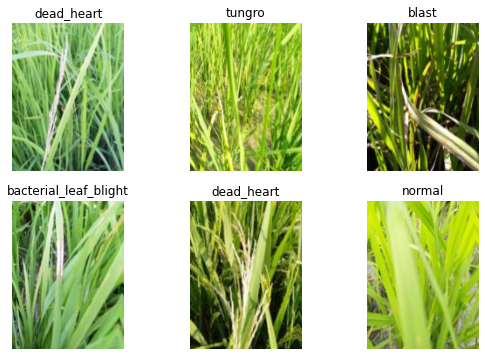

In [30]:
learn.dls.show_batch(max_n=6)

# 5. TTA on validation set

In [31]:
# get validation data loader from leraner 
# It uses 20% of train data as specified in `train` function above
validation_dl = learn.dls.valid

In [32]:
preds, targs = learn.get_preds(dl=validation_dl)

In [33]:
print("Error rate on validation set without TTA", error_rate(preds, targs))

Error rate on validation set without TTA TensorBase(0.0668)


In [34]:
tta_preds, _ = learn.tta(dl=validation_dl)
print("Error rate on validation set without TTA", error_rate(tta_preds, targs))

Error rate on validation set without TTA TensorBase(0.0596)


# 6. Final model for submission
* use original images as an input instead of resized to 256
* increase number of epochs
* keep proportions and use padding with zers (it's the best config accoring Jeremy's notebook, but not according this one. Yet the conclusions of resizing impact vary depending on the seed, so I don't think they matter much).

## 6.1 train

In [ ]:
%%time
learn_final  = train(train_path, "convnext_small.fb_in22k", 
                     Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), 
                     aug_transforms(size=(256, 192), min_scale=0.75), 
                     12)

epoch,train_loss,valid_loss,error_rate,time
0,1.080370,0.582622,0.195579,03:52


epoch,train_loss,valid_loss,error_rate,time


In [ ]:
learn_final.recorder.plot_loss(skip_start=0, with_valid=True)

In [ ]:
tta_preds,targs = learn_final.tta(dl=learn_final.dls.valid)
print("Error rate for the final model with TTA:", error_rate(tta_preds, targs))

## 6.2 Generate scores for submission

In [ ]:
test_files = get_image_files( path / 'test_images').sorted()
test_dl = learn_final.dls.test_dl(test_files)

In [ ]:
predicted_idxs,_ = learn_final.tta(dl=test_dl)

In [ ]:
category_names = learn_final.dls.vocab
category_names

In [ ]:
subm_df = pd.read_csv(path / 'sample_submission.csv')

In [ ]:
subm_df['label'] = category_names[predicted_idxs.numpy()]

In [ ]:
assert subm_df["label"].isnull().sum() == 0

In [ ]:
subm_df.to_csv('subm_p2.csv', index=False)
!head subm.csv

In [ ]:
if not is_kaggle:
    from kaggle import api
    api.competition_submit_cli('subm_p2.csv', 'part2: convnext_small.fb_in22k (256, 192) TTA', COMPETITION_NAME)

# Push notebook to Kaggle

In [ ]:
if not is_kaggle and False:
    push_notebook('stware', 'paddy-02-convnext-resize-tta',
                  title='Paddy: 02 convnext + resize + tta',
                  file='02-convnext-resize-tta.ipynb',
                  competition=COMPETITION_NAME, private=False, gpu=True,  internet=True)